In [1]:
import os
from glob import glob
import numpy as np
import fitsio
from scipy.ndimage import gaussian_filter1d
from matplotlib import pyplot as plt
from time import time
from astropy.io import fits
import pandas as pd
from astropy.cosmology import Planck18
from tqdm import tqdm
from astropy.table import Table
from multiprocessing import Pool
import matplotlib as mpl
from scipy import integrate

In [2]:
zeropoint = fits.open('/pscratch/sd/z/zhaozhon/zero-point/bd_17d4708_stisnic_007.fits')
calib_ws = zeropoint[1].data['WAVELENGTH']
calib_fs = zeropoint[1].data['flux']

In [3]:
file = '/pscratch/sd/z/zhaozhon/desi-ztf-qso-iron-pernight-summary.fits'
files_open = fits.open(file)

In [4]:
# function to read the data
def read_data(zmin, zmax, ramin, ramax, decmin, decmax, band, magmin, magmax):

    # read data
    #fn = "/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits"
    #========================
    #fn = "/global/cfs/cdirs/desi/survey/catalogs/Y1/QSO/iron/QSO_cat_iron_main_dark_healpix_only_qso_targets_v0.fits"
    fn = '/pscratch/sd/z/zhaozhon/desi-ztf-qso-iron-pernight-summary.fits'
    d = Table(fitsio.read(fn))
    d = Table(fitsio.read(file, "FIBERMAP"))
    hpxd = Table(fitsio.read(file, "HPXMASTER"))
    assert np.all(d["TARGETID"] == hpxd["TARGETID"])
    for key in hpxd.colnames:
        if key not in d.colnames:
            d[key] = hpxd[key]
    d["APP_MAG_G"] = 22.5 - 2.5 * np.log10(d["FLUX_G"]) - 3.214 * d["EBV"]
    d["APP_MAG_R"] = 22.5 - 2.5 * np.log10(d["FLUX_R"]) - 1.265 * d["EBV"]
    d["APP_MAGERR_G"] = 2.5 / np.log(10) / (d["FLUX_G"] * np.sqrt(d["FLUX_IVAR_G"]))
    d["APP_MAGERR_R"] = 2.5 / np.log(10) / (d["FLUX_R"] * np.sqrt(d["FLUX_IVAR_R"]))
    #========================
    """
    assert (zmin >= 2.3) & (zmin <= 2.8)
    assert (zmax >= 2.3) & (zmax <= 2.8)
    sel = (d["Z"] > zmin) & (d["Z"] < zmax)
    d = d[sel]
    fn = "/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv"
    k = Table.read(fn, format="csv")
    # hopefully, d and k should be row-matched here...
    assert len(d) == len(k)
    d["K_CORR_G"], d["K_CORR_R"] = k["k_gg"], k["k_rr"]
    print("read {} rows in 2.3 < z < 2.8".format(len(d)))
    """
    
    # remove duplicates
    _, ii = np.unique(d["TARGETID"], return_index=True)
    d = d[ii]
    print("keep {} rows after removing duplicates".format(len(d)))

    # make selection on z, radec, magnitude
    sel = np.ones(len(d), dtype=bool)
    #sel &= (np.isfinite(d["K_CORR_{}".format(band)])) & (np.isfinite(d["K_CORR_{}".format(band)]))
    #print("keep {} rows after cutting on finite K_CORR_{}".format(sel.sum(), band))
    sel &= (d["Z"] > zmin) & (d["Z"] < zmax)
    print("keep {} rows after cutting on {} < z < {}".format(sel.sum(), zmin, zmax))
    sel &= (d["TARGET_RA"] > ramin) & (d["TARGET_RA"] < ramax)
    sel &= (d["TARGET_DEC"] > decmin) & (d["TARGET_DEC"] < decmax)
    print("keep {} rows after cutting on {} < ra < {}, {} < dec < {}".format(sel.sum(), ramin, ramax, decmin, decmax))
    sel &= (d["APP_MAG_{}".format(band)] > magmin) & (d["APP_MAG_{}".format(band)] < magmax)
    print("keep {} rows after cutting on {} < mag_{} < {}".format(sel.sum(), magmin, band.lower(), magmax))
    d = d[sel]
    
    # comoving distance
    d["MU"] = Planck18.distmod(d["Z"]).value

    return d

In [5]:
# settings

zmin, zmax = 2.3, 2.8
#zmin, zmax = 2.0, 3.0
ramin, ramax, decmin, decmax, frac_area = 0., 360., -90., 90., 0.16
#ramin, ramax, decmin, decmax, frac_area = 140., 220., -3., 4., 0.014
band, magmin, magmax = "R", 18., 23.
#band, magmin, magmax = "G", 18., 24.

skyarea = 4 * np.pi * (180 / np.pi) ** 2 # 41253 deg2
d = read_data(zmin, zmax, ramin, ramax, decmin, decmax, band, magmin, magmax)

'''
d = Table(fitsio.read(file, "FIBERMAP"))

hpxd = Table(fitsio.read(file, "HPXMASTER"))
assert np.all(d["TARGETID"] == hpxd["TARGETID"])
for key in hpxd.colnames:
    if key not in d.colnames:
        d[key] = hpxd[key]

print(d.colnames)
sel = (d["EFFTIME_SPEC"] > 800) & (d["EFFTIME_SPEC"] < 1200)
sel &= d["COADD_FIBERSTATUS"] == 0
sel &= (d["FLUX_G"] > 0) & (d["FLUX_R"] > 0)
sel &= (d["FLUX_IVAR_G"] > 0) & (d["FLUX_IVAR_R"] > 0)
d = d[sel]
'''

/tmp/ipykernel_1305693/3631909498.py:18: RuntimeWarning: divide by zero encountered in true_divide
  d["APP_MAGERR_G"] = 2.5 / np.log(10) / (d["FLUX_G"] * np.sqrt(d["FLUX_IVAR_G"]))
/tmp/ipykernel_1305693/3631909498.py:19: RuntimeWarning: divide by zero encountered in true_divide
  d["APP_MAGERR_R"] = 2.5 / np.log(10) / (d["FLUX_R"] * np.sqrt(d["FLUX_IVAR_R"]))


keep 1237825 rows after removing duplicates
keep 171192 rows after cutting on 2.3 < z < 2.8
keep 171192 rows after cutting on 0.0 < ra < 360.0, -90.0 < dec < 90.0
keep 168954 rows after cutting on 18.0 < mag_r < 23.0


'\nd = Table(fitsio.read(file, "FIBERMAP"))\n\nhpxd = Table(fitsio.read(file, "HPXMASTER"))\nassert np.all(d["TARGETID"] == hpxd["TARGETID"])\nfor key in hpxd.colnames:\n    if key not in d.colnames:\n        d[key] = hpxd[key]\n\nprint(d.colnames)\nsel = (d["EFFTIME_SPEC"] > 800) & (d["EFFTIME_SPEC"] < 1200)\nsel &= d["COADD_FIBERSTATUS"] == 0\nsel &= (d["FLUX_G"] > 0) & (d["FLUX_R"] > 0)\nsel &= (d["FLUX_IVAR_G"] > 0) & (d["FLUX_IVAR_R"] > 0)\nd = d[sel]\n'

In [6]:
print(d.colnames)

['TARGETID', 'PETAL_LOC', 'DEVICE_LOC', 'LOCATION', 'FIBER', 'COADD_FIBERSTATUS', 'TARGET_RA', 'TARGET_DEC', 'PMRA', 'PMDEC', 'REF_EPOCH', 'LAMBDA_REF', 'FA_TARGET', 'FA_TYPE', 'OBJTYPE', 'FIBERASSIGN_X', 'FIBERASSIGN_Y', 'PRIORITY', 'SUBPRIORITY', 'OBSCONDITIONS', 'RELEASE', 'BRICKNAME', 'BRICKID', 'BRICK_OBJID', 'MORPHTYPE', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'FIBERTOTFLUX_G', 'FIBERTOTFLUX_R', 'FIBERTOTFLUX_Z', 'MASKBITS', 'SERSIC', 'SHAPE_R', 'SHAPE_E1', 'SHAPE_E2', 'REF_ID', 'REF_CAT', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_PHOT_BP_MEAN_MAG', 'GAIA_PHOT_RP_MEAN_MAG', 'PARALLAX', 'PHOTSYS', 'PRIORITY_INIT', 'NUMOBS_INIT', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'SCND_TARGET', 'PLATE_RA', 'PLATE_DEC', 'TILEID', 'COADD_NUMEXP', 'COADD_EXPTIME', 'COADD_NUMNIGHT', 'COADD_NUMTILE', 'MEAN_DELTA_X', 'RMS_DELTA_X', 'MEAN_DELTA_Y', 'RMS_DELTA_Y', 'MEAN_

In [7]:
'''
d["APP_MAG_G"] = 22.5 - 2.5 * np.log10(d["FLUX_G"]) - 3.214 * d["EBV"]
d["APP_MAG_R"] = 22.5 - 2.5 * np.log10(d["FLUX_R"]) - 2.165 * d["EBV"]
d["APP_MAGERR_G"] = 2.5 / np.log(10) / (d["FLUX_G"] * np.sqrt(d["FLUX_IVAR_G"]))
d["APP_MAGERR_R"] = 2.5 / np.log(10) / (d["FLUX_R"] * np.sqrt(d["FLUX_IVAR_R"]))
'''

'\nd["APP_MAG_G"] = 22.5 - 2.5 * np.log10(d["FLUX_G"]) - 3.214 * d["EBV"]\nd["APP_MAG_R"] = 22.5 - 2.5 * np.log10(d["FLUX_R"]) - 2.165 * d["EBV"]\nd["APP_MAGERR_G"] = 2.5 / np.log(10) / (d["FLUX_G"] * np.sqrt(d["FLUX_IVAR_G"]))\nd["APP_MAGERR_R"] = 2.5 / np.log(10) / (d["FLUX_R"] * np.sqrt(d["FLUX_IVAR_R"]))\n'

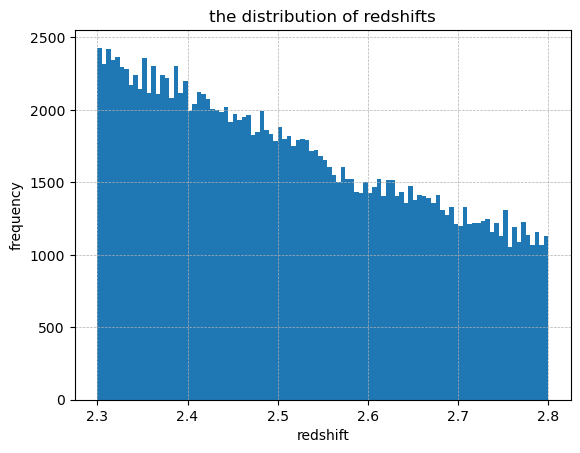

In [8]:
counts, bin_edges, patches = plt.hist(d['Z'], bins=100, histtype='bar')

# If you want to show the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('redshift')
plt.ylabel('frequency')
plt.title('the distribution of redshifts')
plt.savefig('/pscratch/sd/z/zhaozhon/Plots/his-z', dpi=300) 
# Show the plot
plt.show()

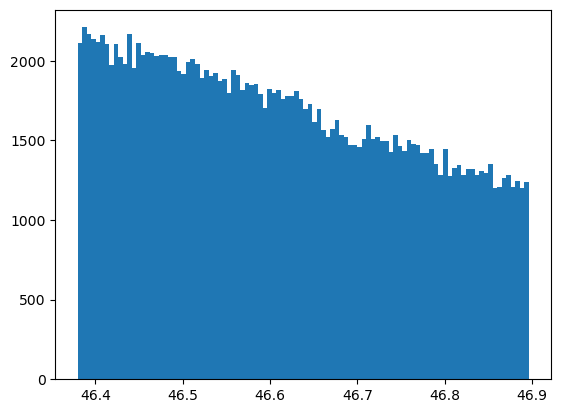

In [9]:
counts, bin_edges, patches = plt.hist(d["MU"], bins=100, histtype='bar')

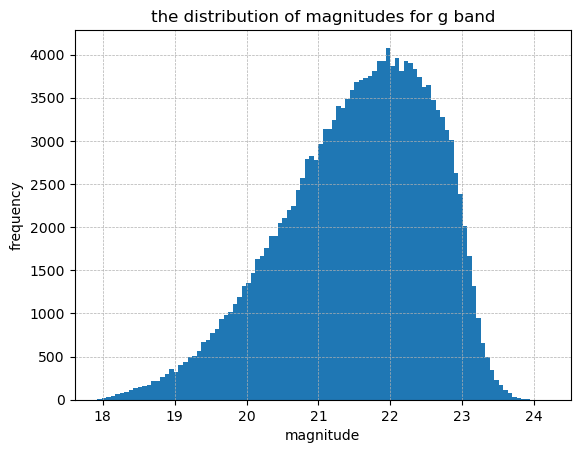

In [10]:
counts, bin_edges, patches = plt.hist(d['APP_MAG_G'], bins=100, histtype='bar')

# If you want to show the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('magnitude')
plt.ylabel('frequency')
plt.title('the distribution of magnitudes for g band')
plt.savefig('/pscratch/sd/z/zhaozhon/Plots/his-mag-g', dpi=300) 
# Show the plot
plt.show()

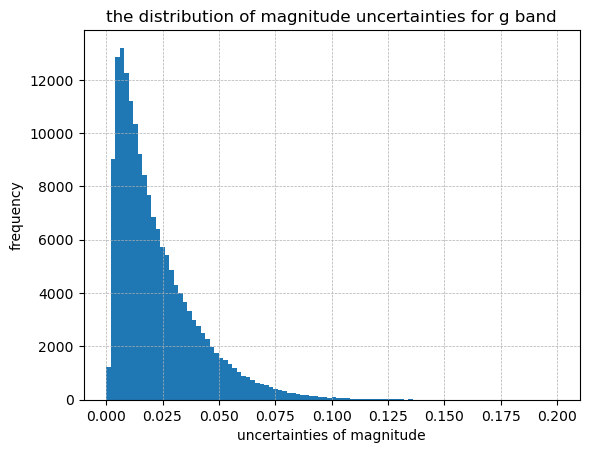

In [11]:
counts, bin_edges, patches = plt.hist(d['APP_MAGERR_G'],range=(0,0.2), bins=100, histtype='bar')

# If you want to show the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('uncertainties of magnitude')
plt.ylabel('frequency')
plt.title('the distribution of magnitude uncertainties for g band')
plt.savefig('/pscratch/sd/z/zhaozhon/Plots/his-mag-g-err', dpi=300) 
# Show the plot
plt.show()

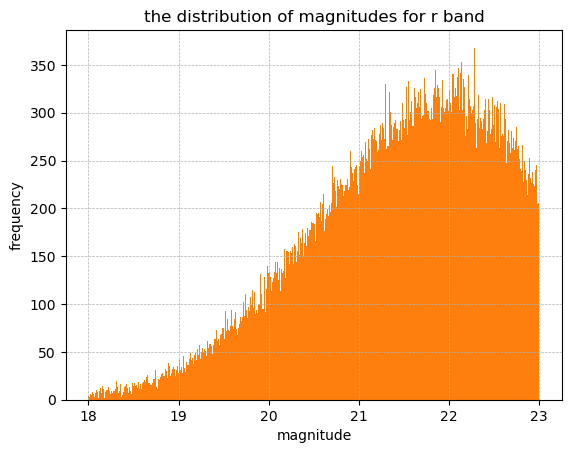

In [12]:
counts, bin_edges, patches = plt.hist(d['APP_MAG_R'],bins=1000, histtype='bar')
counts, bin_edges, patches = plt.hist(d['APP_MAG_R'][d['Z']<2.8],bins=1000, histtype='bar')

# If you want to show the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('magnitude')
plt.ylabel('frequency')
plt.title('the distribution of magnitudes for r band')
plt.savefig('/pscratch/sd/z/zhaozhon/Plots/his-mag-r', dpi=300) 
# Show the plot
plt.show()

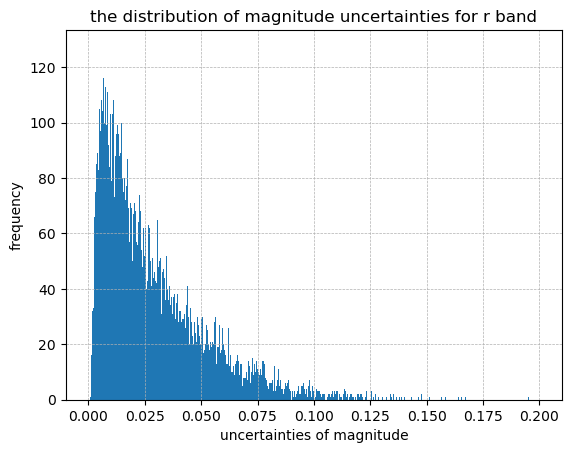

In [13]:
counts, bin_edges, patches = plt.hist(d['APP_MAGERR_R'],range=(0,0.2), bins=10000, histtype='bar')

# If you want to show the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('uncertainties of magnitude')
plt.ylabel('frequency')
plt.title('the distribution of magnitude uncertainties for r band')
plt.savefig('/pscratch/sd/z/zhaozhon/Plots/his-mag-r-err', dpi=300) 
# Show the plot
plt.show()

In [14]:
print(d['Z'].shape)

(168954,)


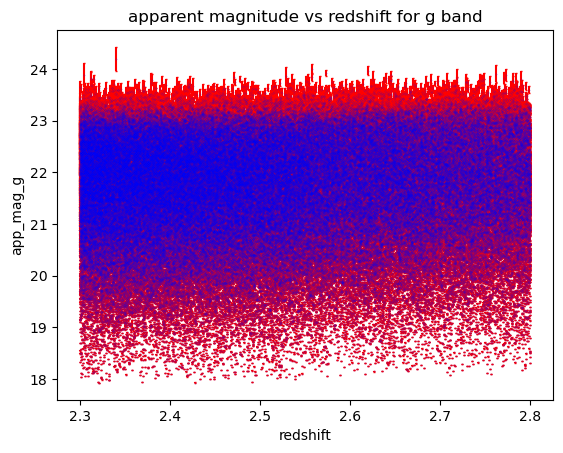

In [15]:
mpl.rcParams['agg.path.chunksize'] = 10000
fig, ax = plt.subplots()  
ax.errorbar(d['Z'], d['APP_MAG_G'], yerr=d['APP_MAGERR_G'],fmt='o', capsize=1, capthick=1, ecolor='red', linestyle='none', color='blue', label='Data points',markersize =0.1 )
ax.set_xlabel('redshift')  
ax.set_ylabel('app_mag_g') 
plt.savefig('/pscratch/sd/z/zhaozhon/Plots/app-z-g', dpi=300) 
plt.title('apparent magnitude vs redshift for g band')
plt.show()

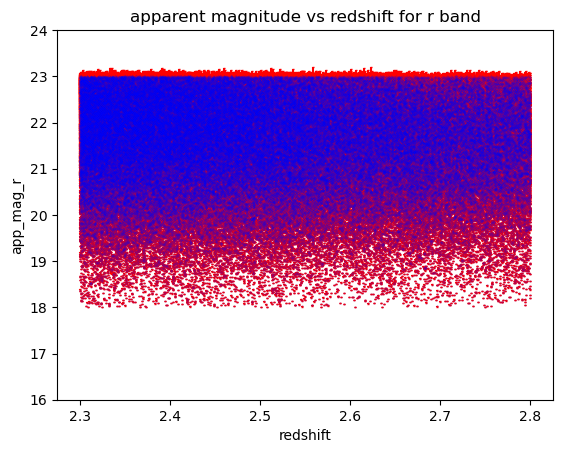

In [16]:
fig, ax = plt.subplots()  
ax.errorbar(d['Z'], d['APP_MAG_R'], yerr=d['APP_MAGERR_R'],fmt='o', capsize=1, capthick=1, ecolor='red', linestyle='none', color='blue', label='Data points',markersize =0.1 )
ax.set_xlabel('redshift')  
ax.set_ylabel('app_mag_r') 
ax.set_ylim(16,24)
plt.savefig('/pscratch/sd/z/zhaozhon/Plots/app-z-r', dpi=300) 
plt.title('apparent magnitude vs redshift for r band')
plt.show()

In [17]:
DECam_g = np.loadtxt('/pscratch/sd/r/raichoor/desi-ztf-qso/decam-filters/CTIO_DECam.g.dat')
ws_g = DECam_g[:,0]
bp_g = DECam_g[:,1]
DECam_r = np.loadtxt('/pscratch/sd/r/raichoor/desi-ztf-qso/decam-filters/CTIO_DECam.r.dat')
ws_r = DECam_r[:,0]
bp_r = DECam_r[:,1]

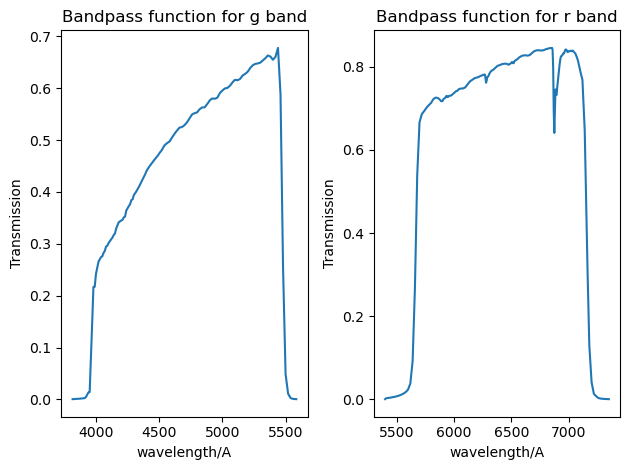

In [18]:
fig, ax = plt.subplots(1,2)  
ax[0].plot(ws_g, bp_g)  
ax[0].set_xlabel('wavelength/A')  
ax[0].set_ylabel('Transmission') 
ax[0].set_title('Bandpass function for g band')  

ax[1].plot(ws_r, bp_r) 
ax[1].set_xlabel('wavelength/A')
ax[1].set_ylabel('Transmission') 
ax[1].set_title('Bandpass function for r band') 
plt.tight_layout()
plt.savefig('/pscratch/sd/z/zhaozhon/Plots/bp', dpi=300) 
plt.show()

In [19]:
array = np.arange(ws_g[0], ws_g[-1] + 0.1, 0.1)
print(array.shape)
print(ws_r[0],ws_r[-1])

(17702,)
5400.0 7350.0


In [20]:
ardir = os.path.join(os.getenv("PSCRATCH", "/pscratch/sd/z/zhaozhon"))#
def get_ws(ardir):
    fn = sorted(
        glob(os.path.join(ardir, "pernight-spectra","desi-ztf-qso-iron-*-*.fits"))
    )[0]
    ws = fitsio.read(fn, "BRZ_WAVE")
    return ws
def get_tid_tileids_nights(tid, all_tids, all_tileids, all_nights):
    sel = all_tids == tid
    return all_tileids[sel], all_nights[sel]
def get_indiv_spectra(tid, tileids, nights, ardir, nwave):

    nobs = len(tileids)

    # read the spectra
    fs = np.zeros((nobs, nwave))  # flux
    ivs = np.zeros((nobs, nwave))  # inverse variance

    # loop on (tileids, nights)
    for i, (tileid, night) in enumerate(zip(tileids, nights)):

        fn = os.path.join(
            ardir,"pernight-spectra",
            "desi-ztf-qso-iron-{}-{}.fits".format(tileid, night),
        )

        # first get the row corresponding to TARGETID
        # (for a given TILEID, a TARGETID can appear only once max.)
        tmp_fm = fitsio.read(fn, "FIBERMAP", columns=["TARGETID"])
        tmp_i = np.where(tmp_fm["TARGETID"] == tid)[0][0]

        # now read the flux, ivar only for that row

        # this is more intuitive, but it loads the whole image first,
        #   then extracts the relevant row, so it s ~slow
        # fs[i, :] = fitsio.read(fn, "BRZ_FLUX")[tmp_i, :]
        # ivs[i, :] = fitsio.read(fn, "BRZ_IVAR")[tmp_i, :]

        # this way is *much* faster, with reading only the relevant row
        #   note: fitsio wants/works with a slice, not an integer...
        h = fitsio.FITS(fn)
        tmp_slice = slice(tmp_i, tmp_i + 1, 1)
        fs[i, :] = h["BRZ_FLUX"][tmp_slice, :]
        ivs[i, :] = h["BRZ_IVAR"][tmp_slice, :]

    return fs, ivs
def k_correction(targetid,ws, fs, ws_bp, bp, z0, z, calib_ws=None, calib_fs=None):
    """
    Compute the k-correction [add details]
    
    Args:
        ws: observed spectrum wavelengths in A (1d np.array())
        fs: observed spectrum flux in 1e-17 * erg/s/cm2/A (1d np.array())
        ws_bp: filter wavelengths in A (np.array())
        bp: filter response (np.array())
        z0: "central" redshift we are k-correcting to (float)
        z: spectrum redshift (float)
        calib_ws (optional, defaults to None): BD +174708 star wavelengths in A  (1d np.array())
        calib_fs (optional, defaults to None): BD +174708 star flux in some units..  (1d np.array())
    
    Returns:
        k: the k-correction value (float)
        
    Notes:
        See Appendix A of https://www.overleaf.com/project/655677d0ea85cf39fc55c558
    """

    # rest-frame wavelengths
    # desi spectra are at 0.8A resolution
    # z approx. is in [2, 4]
    # in rest-frame at z=4, dw_obs=0.8A corresponds to dw_rf=0.16A
    # => we pick a 0.1A sampling
    # for the filter response, we redshift to z0
    ro_ws = np.arange(ws_bp[0], ws_bp[-1] + 0.1, 0.01) #observed frame wavelengths
    obs0_bp = np.interp(ro_ws, ws_bp, bp)

    # compute the numerator term
    rf_ws = np.linspace(1600*(1+z0), 1850*(1+z0), ro_ws.shape[0])
    rf_bp = obs0_bp
    interp_fs = np.interp((1 + z)/(1+z0) * rf_ws, ws, fs)
    num_integrand = rf_ws * rf_bp * interp_fs
    num = np.trapz(num_integrand, x=rf_ws)

    # compute the denominator term
    interp_fs = np.interp(ro_ws,ws,fs)
    denom_integrand = ro_ws*obs0_bp*interp_fs
    denom = np.trapz(denom_integrand, ro_ws)

    # k-correction
    k = 2.5 * np.log10((1 + z)/(1+z0))
    k += 2.5 * np.log10(num / denom)

    # compute ZTF zp correction?
    if calib_ws is not None:

        # Zx term
        interp_calib_fs = np.interp(rf_ws, calib_ws, calib_fs)
        Zx_integrand = rf_ws * obs0_bp * interp_calib_fs
        Zx = np.trapz(Zx_integrand, x=rf_ws)

        # Zy term
        interp_calib_fs = np.interp(ro_ws, calib_ws, calib_fs)
        Zy_integrand = ro_ws * obs0_bp * interp_calib_fs
        Zy = np.trapz(Zy_integrand, x=ro_ws)
        # apply [note: in the paper, there s no 2.5*log10()..]
        k -= 2.5 * np.log10(Zx / Zy)
    
    return k
'''
def k_correction(targetid,ws, fs, ws_bp, bp, z0, z, calib_ws=None, calib_fs=None):
    """
    Compute the k-correction [add details]
    
    Args:
        ws: observed spectrum wavelengths in A (1d np.array())
        fs: observed spectrum flux in 1e-17 * erg/s/cm2/A (1d np.array())
        ws_bp: filter wavelengths in A (np.array())
        bp: filter response (np.array())
        z0: "central" redshift we are k-correcting to (float)
        z: spectrum redshift (float)
        calib_ws (optional, defaults to None): BD +174708 star wavelengths in A  (1d np.array())
        calib_fs (optional, defaults to None): BD +174708 star flux in some units..  (1d np.array())
    
    Returns:
        k: the k-correction value (float)
        
    Notes:
        See Appendix A of https://www.overleaf.com/project/655677d0ea85cf39fc55c558
    """

    # rest-frame wavelengths
    # desi spectra are at 0.8A resolution
    # z approx. is in [2, 4]
    # in rest-frame at z=4, dw_obs=0.8A corresponds to dw_rf=0.16A
    # => we pick a 0.1A sampling
    rf_ws = np.arange(ws_bp[0] / (1 + z0), ws_bp[-1] / (1 + z0) + 0.1, 0.1)

    # for the filter response, we redshift to z0
    obs0_bp = np.interp((1 + z0) * rf_ws, ws_bp, bp)

    # compute the numerator term
    interp_fs = np.interp((1 + z) * rf_ws, ws, fs)
    num_integrand = rf_ws * obs0_bp * interp_fs
    num = np.trapz(num_integrand, x=rf_ws)

    # compute the denominator term
    ro_ws = (1 + z0) * rf_ws #observed frame wavelengths
    interp_fs = np.interp(ro_ws,ws,fs)
    denom_integrand = ro_ws*obs0_bp*interp_fs
    denom = np.trapz(denom_integrand, ro_ws)

    # k-correction
    k = 2.5 * np.log10(1 + z)
    k += 2.5 * np.log10(num / denom)

    # compute ZTF zp correction?
    if calib_ws is not None:

        # Zx term
        interp_calib_fs = np.interp(rf_ws, calib_ws, calib_fs)
        Zx_integrand = rf_ws * obs0_bp * interp_calib_fs
        Zx = np.trapz(Zx_integrand, x=rf_ws)

        # Zy term
        interp_calib_fs = np.interp(ws_bp, calib_ws, calib_fs)
        Zy_integrand = ws_bp * bp * interp_calib_fs
        Zy = np.trapz(Zy_integrand, x=ws_bp)
        # apply [note: in the paper, there s no 2.5*log10()..]
        k -= 2.5 * np.log10(Zx / Zy)
    
    return k
'''

'\ndef k_correction(targetid,ws, fs, ws_bp, bp, z0, z, calib_ws=None, calib_fs=None):\n    """\n    Compute the k-correction [add details]\n    \n    Args:\n        ws: observed spectrum wavelengths in A (1d np.array())\n        fs: observed spectrum flux in 1e-17 * erg/s/cm2/A (1d np.array())\n        ws_bp: filter wavelengths in A (np.array())\n        bp: filter response (np.array())\n        z0: "central" redshift we are k-correcting to (float)\n        z: spectrum redshift (float)\n        calib_ws (optional, defaults to None): BD +174708 star wavelengths in A  (1d np.array())\n        calib_fs (optional, defaults to None): BD +174708 star flux in some units..  (1d np.array())\n    \n    Returns:\n        k: the k-correction value (float)\n        \n    Notes:\n        See Appendix A of https://www.overleaf.com/project/655677d0ea85cf39fc55c558\n    """\n\n    # rest-frame wavelengths\n    # desi spectra are at 0.8A resolution\n    # z approx. is in [2, 4]\n    # in rest-frame at z

In [21]:
ws = get_ws(ardir)
nwave = len(ws)

In [26]:
### Initialize lists to store results
k_gg = []
k_rr = []

# Filter out rows from `d` where np.sum(SEL) == 0
valid_indices = []
for i in tqdm(range(len(d['TARGETID']))):
    targetid = d['TARGETID'][i]
    tileids, nights = get_tid_tileids_nights(targetid, d["TARGETID"], d["TILEID"], d["NIGHT"])

    # Check that all required FITS files exist
    all_exist = True
    for tileid, night in zip(tileids, nights):
        fn = os.path.join(ardir, "pernight-spectra", f"desi-ztf-qso-iron-{tileid}-{night}.fits")
        if not os.path.exists(fn):
            all_exist = False
            break
    
    if not all_exist:
        continue  # Skip this target

    # Now safely call get_indiv_spectra
    fs, ivs = get_indiv_spectra(targetid, tileids, nights, ardir, nwave)
    SEL = (ivs != 0).all(axis=0)
    if np.sum(SEL) == 0:
        continue

    valid_indices.append(i)

# Now filter `d` using the valid indices
d_filtered = d[valid_indices]

# Process the valid targets in `d_filtered`
for i in tqdm(range(len(d_filtered['TARGETID']))):
    targetid = d_filtered['TARGETID'][i]
    tileids, nights = get_tid_tileids_nights(targetid, d_filtered["TARGETID"], d_filtered["TILEID"], d_filtered["NIGHT"])
    fs, ivs = get_indiv_spectra(targetid, tileids, nights, ardir, nwave)
    SEL = (ivs != 0).all(axis=0)
    fs = (fs[:, SEL] * ivs[:, SEL]).sum(axis=0) / ivs[:, SEL].sum(axis=0)
    k_g = k_correction(targetid, ws[SEL], fs, ws_g, bp_g, 2.3, d_filtered['Z'][i], calib_ws, calib_fs)
    k_r = k_correction(targetid, ws[SEL], fs, ws_r, bp_r, 2.3, d_filtered['Z'][i], calib_ws, calib_fs)
    
    # Append the results to the respective lists
    k_gg.append(k_g)
    k_rr.append(k_r)

'''
def process_target(i):
    tileids, nights = get_tid_tileids_nights(d['TARGETID'][i], d["TARGETID"], d["TILEID"], d["NIGHT"])
    fs, ivs = get_indiv_spectra(d['TARGETID'][i], tileids, nights, ardir, nwave)
    SEL = (ivs != 0).all(axis=0)
    fs = (fs[:,SEL] * ivs[:,SEL]).sum(axis=0) / ivs[:,SEL].sum(axis=0)
    k_rr = k_correction(d['TARGETID'][i], ws[SEL], fs, ws_r, bp_r, 2.3, d['Z'][i], calib_ws, calib_fs)
    return k_rr

if __name__ == '__main__':
    with Pool(processes=32) as pool:
        results = list(tqdm(pool.imap(process_target, range(len(d))), total=len(d)))

    k_rr = results
    '''

100%|██████████| 168954/168954 [35:56<00:00, 78.33it/s] 
/tmp/ipykernel_1305693/184655934.py:91: RuntimeWarning: invalid value encountered in log10
  k += 2.5 * np.log10(num / denom)
100%|██████████| 168482/168482 [1:29:56<00:00, 31.22it/s]  


'\ndef process_target(i):\n    tileids, nights = get_tid_tileids_nights(d[\'TARGETID\'][i], d["TARGETID"], d["TILEID"], d["NIGHT"])\n    fs, ivs = get_indiv_spectra(d[\'TARGETID\'][i], tileids, nights, ardir, nwave)\n    SEL = (ivs != 0).all(axis=0)\n    fs = (fs[:,SEL] * ivs[:,SEL]).sum(axis=0) / ivs[:,SEL].sum(axis=0)\n    k_rr = k_correction(d[\'TARGETID\'][i], ws[SEL], fs, ws_r, bp_r, 2.3, d[\'Z\'][i], calib_ws, calib_fs)\n    return k_rr\n\nif __name__ == \'__main__\':\n    with Pool(processes=32) as pool:\n        results = list(tqdm(pool.imap(process_target, range(len(d))), total=len(d)))\n\n    k_rr = results\n    '

In [27]:
os.path.exists(os.path.join(ardir, "pernight-spectra", f"desi-ztf-qso-iron-{1}-{1}.fits"))

False

In [28]:
k_gg = np.array(k_gg)
k_rr = np.array(k_rr)
print(k_rr.shape)

(168482,)


In [29]:
'''
# Filter out None results
filtered_results = [res for res in results]

# Separate into lists
k_gg, k_rr = zip(*filtered_results)
k_gg = np.array(k_gg)
k_rr = np.array(k_rr)
'''

'\n# Filter out None results\nfiltered_results = [res for res in results]\n\n# Separate into lists\nk_gg, k_rr = zip(*filtered_results)\nk_gg = np.array(k_gg)\nk_rr = np.array(k_rr)\n'

In [30]:
t = Table([k_gg,k_rr], 
          names=('k_gg','k_rr'))
t.write('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k1.csv', format='csv', overwrite=True)

In [31]:
d_filtered.write('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits', format='fits', overwrite=True)